In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm


from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.core.exceptions import NoHits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [3]:
#Dimensions for the NEXT100 detector
veto_N100 = 20 # mm
rmax_N100 = 492 - veto_N100
zmin_N100 = veto_N100
zmax_N100 = 1205 - veto_N100

In [4]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaDS/'
max0nubbf = 999
maxselectron = 999
blobR = 21
testID = '_oec'

## Opening TRACK Files - 0nubb

In [5]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm{testID}.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb.columns  

#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [6]:
#same for selectron files
track_list_selectron = []
filepath_selectron_tracks = filepath+f'/e-_roi/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,maxselectron):
    
    filename_selectron = filepath_selectron_tracks+f'next100.e-_roi.{nfile}.skel_tracks.R{blobR}mm{testID}.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks_selectron = pd.read_hdf(filename_selectron, 'Tracks')
    except:
        print('File {} not good'.format(filename_selectron))
        continue
        
    track_list_selectron.append(readfile_tracks_selectron)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_selectron = pd.concat([dt for dt in track_list_selectron]) 
tracks_selectron.columns  

#these are all the elements inside the file:

File /Users/halmamol/NEXT/files/NEXT100/beershebaDS//e-_roi/tracks/21mm/next100.e-_roi.820.skel_tracks.R21mm_oec.h5 not good


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

## Checkig DECO tracks

#0nubb files
deco_list_0nubb = []

filepath_0nubb_deco = filepath+f'0nubb/hits/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.{nfile}.deconv_tb.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    deco_list_0nubb.append(readfile_deco)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

deco_0nubb = pd.concat([dt for dt in deco_list_0nubb]) 
deco_0nubb.columns  

base_vsize = 5 #mm
this_evt_df = deco_0nubb[deco_0nubb.event == 100]
the_hits = []

xs = this_evt_df.X
ys = this_evt_df.Y
zs = this_evt_df.Z
es = this_evt_df.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

ax.set_xlim([-40, 80])
ax.set_ylim([-450, -330])
ax.set_zlim([950, 1020])
#ax.view_init(30, 210)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

## Checking cuts

interested in selecting the events in/with:
- **Fiducial**: fiducial cut around the detector volume, of 2cm from the border
- **1Track**: in this case, considers the track with highest deposition
- **NoOverlap**: defined blobs in one trace should not overlap
- **ROI**: energy cut in the region of interest, between [2.445,2475]MeV

In [7]:
#Checking total amount of events, prior any selection
nevents_0nubb_total = tracks_0nubb.event.nunique()
Enevents_0nubb_total = np.sqrt(nevents_0nubb_total)
print(f'Initial amount of events for 0nubb: {nevents_0nubb_total} +- {Enevents_0nubb_total}')

Initial amount of events for 0nubb: 9800 +- 98.99494936611666


In [8]:
nevents_selectron_total = tracks_selectron.event.nunique()
Enevents_selectron_total = np.sqrt(nevents_selectron_total)
print(f'Initial amount of events for selectrons: {nevents_selectron_total} +- {Enevents_selectron_total}')

Initial amount of events for selectrons: 9753 +- 98.75727821279807


### 1 - FIDUCIAL CUT

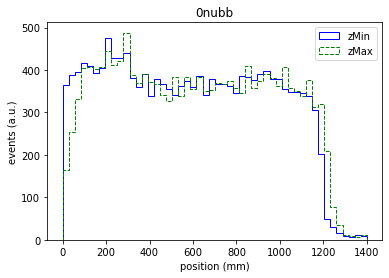

In [9]:
track_0nubb_zmin = tracks_0nubb.z_min
track_0nubb_zmax = tracks_0nubb.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

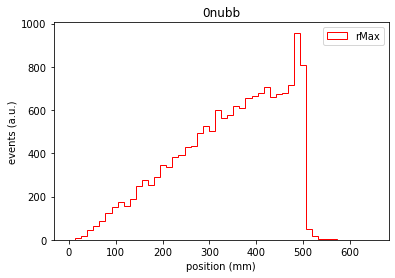

In [10]:
track_0nubb_rmax = tracks_0nubb.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

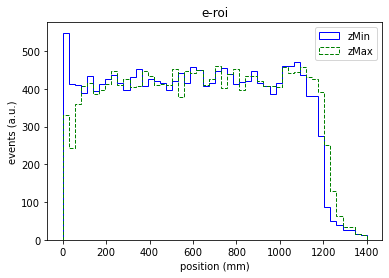

In [11]:
track_selectron_zmin = tracks_selectron.z_min
track_selectron_zmax = tracks_selectron.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

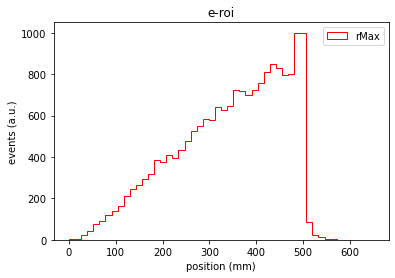

In [12]:
track_selectron_rmax = tracks_selectron.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

In [13]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- Rmax = {np.amax(track_0nubb_rmax)}')
print(f'- Zmin = {np.amax(track_0nubb_zmin)}')
print(f'- Zmax = {np.amax(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.amax(track_selectron_rmax)}')
print(f'- Zmin = {np.amax(track_selectron_zmin)}')
print(f'- Zmax = {np.amax(track_selectron_zmax)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- Rmax = {np.average(track_0nubb_rmax)}')
print(f'- Zmin = {np.average(track_0nubb_zmin)}')
print(f'- Zmax = {np.average(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.average(track_selectron_rmax)}')
print(f'- Zmin = {np.average(track_selectron_zmin)}')
print(f'- Zmax = {np.average(track_selectron_zmax)}')

MAX VALUE
0nubb
- Rmax = 566.1982868218519
- Zmin = 1455.0408750000001
- Zmax = 1463.791125
e-roi
- Rmax = 560.8979408056335
- Zmin = 1454.1785
- Zmax = 1463.777625
AVG VALUE
0nubb
- Rmax = 342.8420528013632
- Zmin = 586.6095692944433
- Zmax = 616.3203626540112
e-roi
- Rmax = 344.6484547912528
- Zmin = 605.2494473772896
- Zmax = 636.5009759837492


In [14]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/tracklimits_DETSIM{testID}'
np.savez(npz_file, track_0nubb_zmin=track_0nubb_zmin, track_0nubb_zmax=track_0nubb_zmax, track_0nubb_rmax=track_0nubb_rmax,
        track_selectron_zmin=track_selectron_zmin, track_selectron_zmax=track_selectron_zmax, track_selectron_rmax=track_selectron_rmax)


In [15]:
#For the evaluation of the events out of fiducial limits it's necessary to do several steps

#First, check a list of events where at least 1 trace is out of the limits:

nonfiducial_list_0nubb = tracks_0nubb[~((tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_0nubb = tracks_0nubb[(tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_0nubb    = ~fiducial_tracks_0nubb.event.isin(nonfiducial_list_0nubb) 

# And finally I select the events with an asigned True from the previous line 
tracks_0nubb_fiducial = fiducial_tracks_0nubb[evt_fid_sel_0nubb]

In [16]:
#Now I do the same for single electron

nonfiducial_list_selectron = tracks_selectron[~((tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_selectron = tracks_selectron[(tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_selectron    = ~fiducial_tracks_selectron.event.isin(nonfiducial_list_selectron) 

# And finally I select the events with an asigned True from the previous line 
tracks_selectron_fiducial = fiducial_tracks_selectron[evt_fid_sel_selectron]

In [17]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_fiducial = tracks_0nubb_fiducial.event.nunique()
Enevents_0nubb_fiducial = np.sqrt(nevents_0nubb_fiducial)


ratio_fiducial_0nubb = 100*nevents_0nubb_fiducial/nevents_0nubb_total
Eratio_fiducial_0nubb = myef.ratio_error(ratio_fiducial_0nubb, nevents_0nubb_fiducial, nevents_0nubb_total, 
                                             Enevents_0nubb_fiducial, Enevents_0nubb_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9800        
FIDUCIAL   7254                ---      74.0204081632653 +- 1.1464702547376697%
--------!--------------!----------------!----------------


In [18]:
nevents_selectron_fiducial = tracks_selectron_fiducial.event.nunique()
Enevents_selectron_fiducial = np.sqrt(nevents_selectron_fiducial)

ratio_fiducial_selectron = 100*nevents_selectron_fiducial/nevents_selectron_total
Eratio_fiducial_selectron = myef.ratio_error(ratio_fiducial_selectron, nevents_selectron_fiducial, nevents_selectron_total, 
                                             Enevents_selectron_fiducial, Enevents_selectron_total)

print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9753        
FIDUCIAL   6908                ---      70.82948836255511 +- 1.1138311522571196%
--------!--------------!----------------!----------------


## 2 - Number of tracks

In [19]:
#Therefore, I'm going to take the 1st 'trackID'
tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.trackID == 0]

In [20]:
tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]
tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.trackID == 0]

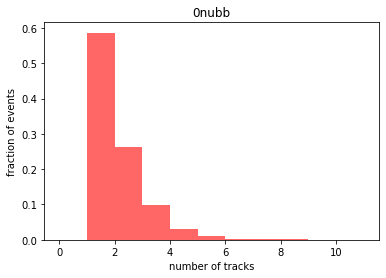

In [21]:
#Check the number of tracks with numb_of_tracks
ntracks_0nubb = tracks_0nubb_1trackfid.numb_of_tracks
maxtracks_0nubb = np.amax(ntracks_0nubb)

plt.hist(ntracks_0nubb, bins = maxtracks_0nubb, range = (0, maxtracks_0nubb),density=True, alpha=0.6, color='r')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('0nubb')
plt.show()

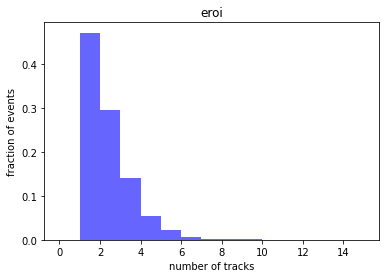

In [22]:
#Check the number of tracks with numb_of_tracks
ntracks_eroi = tracks_selectron_1trackfid.numb_of_tracks
maxtracks_eroi = np.amax(ntracks_eroi)

plt.hist(ntracks_eroi, bins = maxtracks_eroi, range = (0, maxtracks_eroi), density=True, alpha=0.6, color='b')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('eroi')
plt.show()

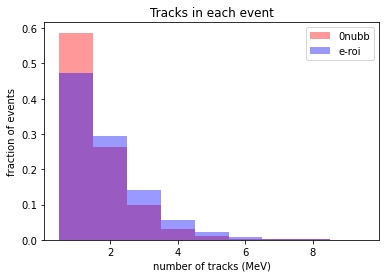

In [23]:
plt.hist(ntracks_0nubb, bins = 9, range = (0.5, 9.5),density=True, alpha=0.4, color='r', label = '0nubb')
plt.hist(ntracks_eroi, bins = 9, range = (0.5, 9.5), density=True, alpha=0.4, color='b',label = 'e-roi')

plt.xlabel('number of tracks (MeV)')
plt.ylabel('fraction of events')
plt.title('Tracks in each event')
plt.legend(loc=1);
plt.show()

In [24]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- #tracks = {np.amax(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.amax(ntracks_eroi)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- #tracks = {np.average(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.average(ntracks_eroi)}')

MAX VALUE
0nubb
- #tracks = 11
e-roi
- #tracks = 15
AVG VALUE
0nubb
- #tracks = 1.6527433140336367
e-roi
- #tracks = 1.911696583671106


In [25]:
tracks_0nubb_1track_cut = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.numb_of_tracks == 1]
frac_1track_0nubb = 100*tracks_0nubb_1track_cut.event.nunique()/nevents_0nubb_fiducial

Efrac_1track_0nubb = myef.ratio_error(frac_1track_0nubb, tracks_0nubb_1track_cut.event.nunique(), nevents_0nubb_fiducial, 
                                             np.sqrt(tracks_0nubb_1track_cut.event.nunique()), np.sqrt(nevents_0nubb_fiducial))
print(f'Amount of events with 1 track 0nubb = {tracks_0nubb_1track_cut.event.nunique()}/{nevents_0nubb_fiducial} = {frac_1track_0nubb} +- {Efrac_1track_0nubb}')

Amount of events with 1 track 0nubb = 4254/7254 = 58.64350703060381 +- 1.1324846978365162


In [26]:
tracks_selectron_1track_cut = tracks_selectron_1trackfid[tracks_selectron_1trackfid.numb_of_tracks == 1]
frac_1track_selectron = 100*tracks_selectron_1track_cut.event.nunique()/nevents_selectron_fiducial
Efrac_1track_selectron = myef.ratio_error(frac_1track_selectron, tracks_selectron_1track_cut.event.nunique(), nevents_selectron_fiducial, 
                                             np.sqrt(tracks_selectron_1track_cut.event.nunique()), np.sqrt(nevents_selectron_fiducial))
print(f'Amount of events with 1 track eroi = {frac_1track_selectron} +- {Efrac_1track_selectron}')

Amount of events with 1 track eroi = 47.23508975101332 +- 1.0033717533126147


In [27]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_1track = tracks_0nubb_1track.event.nunique()
Enevents_0nubb_1track = np.sqrt(nevents_0nubb_1track)
nevents_0nubb_1trackfid = tracks_0nubb_1trackfid.event.nunique()
Enevents_0nubb_1trackfid = np.sqrt(nevents_0nubb_1trackfid)


ratio_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial
Eratio_1trackfid_0nubb = myef.ratio_error(ratio_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_fiducial, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_fiducial)

eff_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_total
Eeff_1trackfid_0nubb = myef.ratio_error(eff_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_total)


print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')

print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9800        
FIDUCIAL   7254                ---      74.0204081632653 +- 1.1464702547376697%
1TRACK.    7254        100.0+- 1.6604516046223932% 74.0204081632653 +- 1.1464702547376697%
--------!--------------!----------------!----------------


In [28]:
nevents_selectron_1track = tracks_selectron_1track.event.nunique()
Enevents_selectron_1track = np.sqrt(nevents_selectron_1track)
nevents_selectron_1trackfid = tracks_selectron_1trackfid.event.nunique()
Enevents_selectron_1trackfid = np.sqrt(nevents_selectron_1trackfid)

ratio_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_fiducial
Eratio_1trackfid_selectron = myef.ratio_error(ratio_1trackfid_0nubb, nevents_selectron_1trackfid, nevents_selectron_fiducial, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_fiducial)

eff_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_total
Eeff_1trackfid_selectron = myef.ratio_error(eff_1trackfid_selectron, nevents_selectron_1trackfid, nevents_selectron_total, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_total)

print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9753        
FIDUCIAL   6908                ---      70.82948836255511 +- 1.1138311522571196%
1TRACK.    6908        100.0+- 1.7015269548251433% 70.82948836255511 +- 1.1138311522571196%
--------!--------------!----------------!----------------


## 3 - No overlap

In [29]:
#Getting ovlp variable of the tracks, and selecting events with no ovlp

tracks_0nubb_ovlp = tracks_0nubb[tracks_0nubb.ovlp_blob_energy == 0.]
tracks_0nubb_ovlp1trackfid = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.ovlp_blob_energy == 0.]

In [30]:
tracks_selectron_ovlp = tracks_selectron[tracks_selectron.ovlp_blob_energy == 0.]
tracks_selectron_ovlp1trackfid = tracks_selectron_1trackfid[tracks_selectron_1trackfid.ovlp_blob_energy == 0.]

In [31]:
#Checking total amount of events, after overlap selection

nevents_0nubb_ovlp = tracks_0nubb_ovlp.event.nunique()
Enevents_0nubb_ovlp = np.sqrt(nevents_0nubb_ovlp)
nevents_0nubb_ovlp1trackfid = tracks_0nubb_ovlp1trackfid.event.nunique()
Enevents_0nubb_ovlp1trackfid = np.sqrt(nevents_0nubb_ovlp1trackfid)


ratio_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid
Eratio_ovlp1trackfid_0nubb = myef.ratio_error(ratio_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_1trackfid, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_1trackfid)

eff_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total
Eeff_ovlp1trackfid_0nubb = myef.ratio_error(eff_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_total)


print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9800        
FIDUCIAL   7254                ---      74.0204081632653 +- 1.1464702547376697%
1TRACK.    7254        100.0+- 1.6604516046223932% 74.0204081632653 +- 1.1464702547376697%
OVLP       4506        62.117452440033084+- 1.1782377352171758%   45.97959183673469 +- 0.8275906787449514%
--------!--------------!----------------!----------------


In [32]:
nevents_selectron_ovlp = tracks_selectron_ovlp.event.nunique()
Enevents_selectron_ovlp = np.sqrt(nevents_selectron_ovlp)
nevents_selectron_ovlp1trackfid = tracks_selectron_ovlp1trackfid.event.nunique()
Enevents_selectron_ovlp1trackfid = np.sqrt(nevents_selectron_ovlp1trackfid)

ratio_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid
Eratio_ovlp1trackfid_selectron = myef.ratio_error(ratio_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_1trackfid, 
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_1trackfid)

eff_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_total
Eeff_ovlp1trackfid_selectron = myef.ratio_error(eff_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_total,
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_total)

print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9753        
FIDUCIAL   6908                ---      70.82948836255511 +- 1.1138311522571196%
1TRACK.    6908        100.0+- 1.7015269548251433% 70.82948836255511 +- 1.1138311522571196%
OVLP       5261        76.1580775911986+- 1.3935838447939175%   53.94237670460371 +- 0.9227308065695926%
--------!--------------!----------------!----------------


## 4 - ROI events

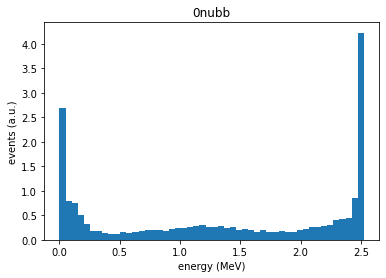

In [33]:
#Getting energy of the tracks
energy_0nubb = tracks_0nubb.energy

plt.hist(energy_0nubb, bins = 50, density = True)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

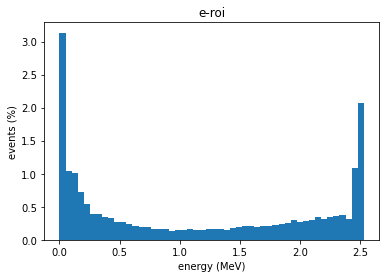

In [34]:
#Getting energy of the tracks
energy_selectron = tracks_selectron.energy

plt.hist(energy_selectron, bins = 50, density = True)
plt.xlabel('energy (MeV)')
plt.ylabel('events (%)')
plt.title('e-roi')
plt.show()

In [35]:
#Check limits of the Energy ROI 

emin = 2.40
emax = 2.54

In [36]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]


In [37]:

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


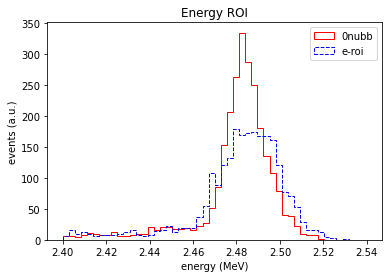

In [38]:
energy_0nubb = tracks_0nubb_ROIovlp1trackfid.energy
energy_selectron = tracks_selectron_ROIovlp1trackfid.energy

plt.hist(energy_0nubb, bins = 50, range = (emin, emax), color='red', histtype='step', label = '0nubb')
plt.hist(energy_selectron, bins = 50, range = (emin, emax), color='blue', histtype='step', label = 'e-roi', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Energy ROI')
plt.legend(loc=1);
plt.show()

In [39]:
#Checking total amount of events, after ROI selection
nevents_0nubb_ROI = tracks_0nubb_ROI.event.nunique()
Enevents_0nubb_ROI = np.sqrt(nevents_0nubb_ROI)
nevents_0nubb_ROIovlp1trackfid = tracks_0nubb_ROIovlp1trackfid.event.nunique()
Enevents_0nubb_ROIovlp1trackfid = np.sqrt(nevents_0nubb_ROIovlp1trackfid)


ratio_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_ovlp1trackfid
Eratio_ROIovlp1trackfid_0nubb = myef.ratio_error(ratio_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_ovlp1trackfid, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_ovlp1trackfid)

eff_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_total
Eeff_ROIovlp1trackfid_0nubb = myef.ratio_error(eff_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_total)

  
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print(f'ROI        {nevents_0nubb_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_0nubb}+- {Eratio_ROIovlp1trackfid_0nubb}%   {eff_ROIovlp1trackfid_0nubb} +- {Eeff_ROIovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9800        
FIDUCIAL   7254                ---      74.0204081632653 +- 1.1464702547376697%
1TRACK.    7254        100.0+- 1.6604516046223932% 74.0204081632653 +- 1.1464702547376697%
OVLP       4506        62.117452440033084+- 1.1782377352171758%   45.97959183673469 +- 0.8275906787449514%
ROI        2566        56.94629383044829+- 1.4083567218675186%   26.183673469387756 +- 0.5806358322765652%
--------!--------------!----------------!----------------
 


In [40]:
nevents_selectron_ROI = tracks_selectron_ROI.event.nunique()
Enevents_selectron_ROI = np.sqrt(nevents_selectron_ROI)
nevents_selectron_ROIovlp1trackfid = tracks_selectron_ROIovlp1trackfid.event.nunique()
Enevents_selectron_ROIovlp1trackfid = np.sqrt(nevents_selectron_ROIovlp1trackfid)

ratio_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_ovlp1trackfid
Eratio_ROIovlp1trackfid_selectron = myef.ratio_error(ratio_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_ovlp1trackfid, 
                                             Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_ovlp1trackfid)

eff_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_total
Eeff_ROIovlp1trackfid_selectron = myef.ratio_error(eff_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_total,
                                                   Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_total)
  
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print(f'ROI        {nevents_selectron_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_selectron}+- {Eratio_ROIovlp1trackfid_selectron}%   {eff_ROIovlp1trackfid_selectron} +- {Eeff_ROIovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')

--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9753        
FIDUCIAL   6908                ---      70.82948836255511 +- 1.1138311522571196%
1TRACK.    6908        100.0+- 1.7015269548251433% 70.82948836255511 +- 1.1138311522571196%
OVLP       5261        76.1580775911986+- 1.3935838447939175%   53.94237670460371 +- 0.9227308065695926%
ROI        2390        45.428625736551986+- 1.120612851474807%   24.505280426535425 +- 0.5593126110564391%
--------!--------------!----------------!----------------


In [81]:
ntracks_0nubb_after = tracks_0nubb_ROIovlp1trackfid.numb_of_tracks
ntracks_selectron_after = tracks_selectron_ROIovlp1trackfid.numb_of_tracks

## Blob Assignation

### SIGNAL EVENTS

reco_0nubb_e = []

reco_0nubb_e = myrvt.blobassignation_notrue(tracks_0nubb, tracks_0nubb_ROIovlp1trackfid)

plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], reco_0nubb_e[2], weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

### BACKGROUND EVENTS

reco_selectron_e = []

reco_selectron_e = myrvt.blobassignation_notrue(tracks_selectron, tracks_selectron_ROIovlp1trackfid)

plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55),color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], reco_selectron_e[2], weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[2], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[1], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

## Representing RECO vs TRUE

In [41]:
#0nubb hit files taken from FULLSIM simulations
hits_list_0nubb = []
filepath_0nubb_hits = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/'


filename_0nubb_hits = filepath_0nubb_hits+f'next100.0nubb.1.deconv.h5'
h5file = tb.open_file(filename_0nubb_hits)
h5file

File(filename=/Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.1.deconv.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/DECO (Group) ''
/DECO/Events (Table(254988,), shuffle, zlib(4)) 'Deconvolved hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "npeak": UInt64Col(shape=(), dflt=0, pos=1),
  "X": Float64Col(shape=(), dflt=0.0, pos=2),
  "Y": Float64Col(shape=(), dflt=0.0, pos=3),
  "Z": Float64Col(shape=(), dflt=0.0, pos=4),
  "E": Float64Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (1365,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}
/MC (Group) ''
/MC/configuration (Table(41,), shuffle, zlib(4)) ''
  description := {
  "param_key": StringCol(itemsize=300, shape=(), dflt=b'', pos=0),
  "param_value": StringCol(itemsize=300, sh

In [42]:
#0nubb files
true_list_0nubb = []
filepath_0nubb_true = filepath_0nubb_hits

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true = filepath_0nubb_true+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb = pd.read_hdf(filename_0nubb_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_0nubb_true))
        continue
        
    true_list_0nubb.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb = pd.concat([dt for dt in true_list_0nubb]) 
true_0nubb.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [43]:
true_0nubb_primary = true_0nubb[true_0nubb.primary == True]
true_0nubb_primary_part1 = true_0nubb_primary[true_0nubb_primary.particle_id == 1]
true_0nubb_primary_part2 = true_0nubb_primary[true_0nubb_primary.particle_id == 2]
true_0nubb_event0 = true_0nubb[true_0nubb.event_id == 0]

In [44]:
diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b1_z_0nubb = [], [], []
diff_b2_x_0nubb, diff_b2_y_0nubb, diff_b2_z_0nubb = [], [], []

reco_0nubb_e = []

diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b2_x_0nubb, diff_b2_y_0nubb, reco_0nubb_e = myrvt.blobassignation(true_0nubb, tracks_0nubb_ROIovlp1trackfid, 'signal')

Total events = 2519
Events 12 = 1308 (51.92536720921%)
Events 21 = 1211 (48.07463279079%)
Events NA = 0 (0.0%)


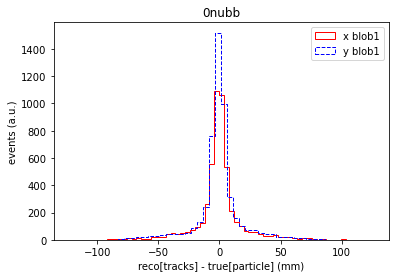

In [45]:
plt.hist(diff_b1_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

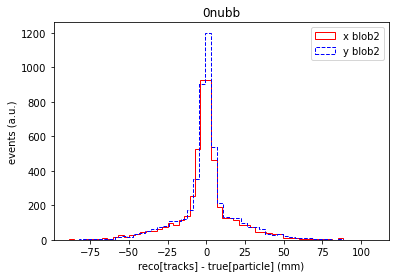

In [46]:
plt.hist(diff_b2_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

In [47]:
#single electron files
true_list_selectron = []
filepath_selectron_true = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/e-_roi/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_selectron_true = filepath_selectron_true+f'next100.e-_roi.{nfile}.deconv.h5'

    try:
        readfile_true_selectron = pd.read_hdf(filename_selectron_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_selectron_true))
        continue
        
    true_list_selectron.append(readfile_true_selectron)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_selectron = pd.concat([dt for dt in true_list_selectron]) 
true_selectron.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [48]:
true_selectron_primary = true_selectron[true_selectron.primary == True]

true_selectron_primary_part1 = true_selectron_primary[true_selectron_primary.particle_id == 1]
true_selectron_primary_part2 = true_selectron_primary[true_selectron_primary.particle_id == 2]

In [49]:
diff_b1_x_selectron, diff_b1_y_selectron, diff_b1_z_selectron = [], [], []
diff_b2_x_selectron, diff_b2_y_selectron, diff_b2_z_selectron = [], [], []

reco_selectron_e = []

diff_b1_x_selectron, diff_b1_y_selectron, diff_b2_x_selectron, diff_b2_y_selectron, reco_selectron_e = myrvt.blobassignation(true_selectron, tracks_selectron_ROIovlp1trackfid, 'bkg')

Total events = 2350
Events 12 = 283 (12.042553191489361%)
Events 21 = 2067 (87.95744680851064%)
Events NA = 0 (0.0%)


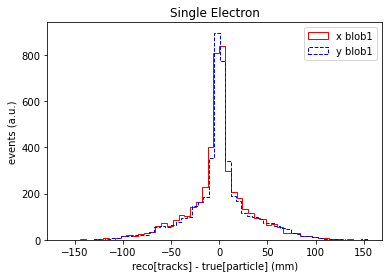

0.21410802411999905

In [50]:
plt.hist(diff_b1_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()
(np.mean(diff_b1_x_selectron)+np.mean(diff_b1_y_selectron))/2

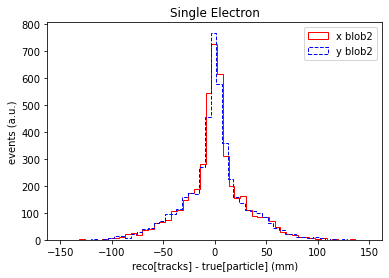

-0.37344476500270246

In [51]:
plt.hist(diff_b2_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

(np.mean(diff_b2_x_selectron)+np.mean(diff_b2_y_selectron))/2

In [52]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/recovstrue_DETSIM_R{blobR}mm{testID}'
np.savez(npz_file, diff_b1_x_0nubb=diff_b1_x_0nubb, diff_b1_y_0nubb=diff_b1_y_0nubb, diff_b1_z_0nubb=diff_b1_z_0nubb,
          diff_b2_x_0nubb=diff_b2_x_0nubb, diff_b2_y_0nubb=diff_b2_y_0nubb, diff_b2_z_0nubb=diff_b2_z_0nubb,
         diff_b1_x_selectron=diff_b1_x_selectron, diff_b1_y_selectron=diff_b1_y_selectron, diff_b1_z_selectron=diff_b1_z_selectron,
         diff_b2_x_selectron=diff_b2_x_selectron, diff_b2_y_selectron=diff_b2_y_selectron, diff_b2_z_selectron=diff_b2_z_selectron)


### Blob energies

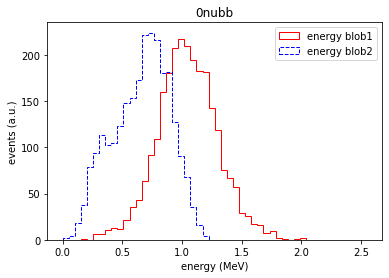

In [53]:
plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

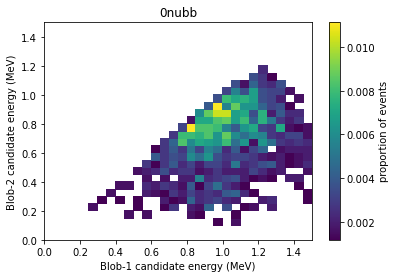

In [54]:
weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], reco_0nubb_e[2], weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

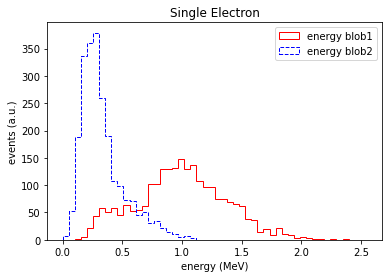

In [55]:
plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55),color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

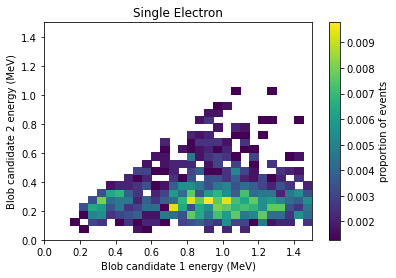

In [56]:
weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], reco_selectron_e[2], weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

## Efficiency Values and FOM Estimation

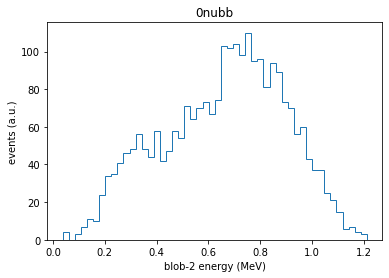

In [57]:
plt.hist(reco_0nubb_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

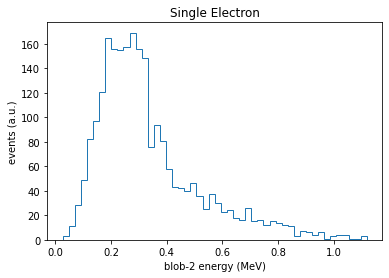

Total events 2350


In [58]:
plt.hist(reco_selectron_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e[0])}')

Since I need to compare both simulations, I'm going to use the same energy cuts. Besides, they seem reasonable looking into the blob2 energy distribution:

In [59]:
blobcut_energy=[]
#in MeV
minEcut = 0.010
maxEcut = 0.800
stepsEcut = 0.010

#defining the vector with the cut values
blobcut_energy=myef.blobthreshold(minEcut,maxEcut,stepsEcut)

In [60]:
if(len(reco_0nubb_e[0])!=len(reco_0nubb_e[1])):
    print(len(reco_0nubb_e[0]))
    print(len(reco_0nubb_e[1]))
    test = reco_0nubb_e[0][:-1].copy()
    print(len(test))
    reco_0nubb_e[0] = test

2519
2518
2518


Now I'm going to take the information from reco_selectron_e[][], to see how many events with each cut I get:

In [61]:
blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron = [], [] 

blobcut_energy_nevents_0nubb = myef.nevents_afterthreshold(blobcut_energy, reco_0nubb_e)
blobcut_energy_nevents_selectron = myef.nevents_afterthreshold(blobcut_energy, reco_selectron_e)

blobcut_energy_nevents_0nubb = np.array(blobcut_energy_nevents_0nubb, dtype=np.float)
blobcut_energy_nevents_selectron = np.array(blobcut_energy_nevents_selectron, dtype=np.float)

Create now arrays containing the statistical uncertainty (sqrt from total amount of events)

In [62]:
blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error= [], []

blobcut_energy_nevents_0nubb_error = myef.sqrterror_array(blobcut_energy_nevents_0nubb)
blobcut_energy_nevents_selectron_error = myef.sqrterror_array(blobcut_energy_nevents_selectron)

Text(0.5, 0, 'blob-2 energy threshold (MeV)')

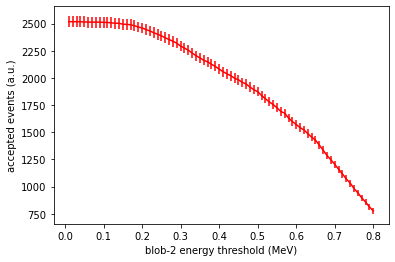

In [63]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,blobcut_energy_nevents_0nubb, yerr=blobcut_energy_nevents_0nubb_error, fmt = '-r')
plt.ylabel('accepted events (a.u.)')
plt.xlabel('blob-2 energy threshold (MeV)')
#plt.title('Cut efficiency')

Now that I have checked the accepted events for each energy cut, I'm going to compute the efficiency/background values:

In [64]:
fom_error, e_error, b_error = [], [], []

e, b, fom, e_error, b_error, fom_error = myef.efficiencyterms(blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron, 
                            blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error,
                            reco_0nubb_e, reco_selectron_e)

Text(0.5, 0, 'background rejection')

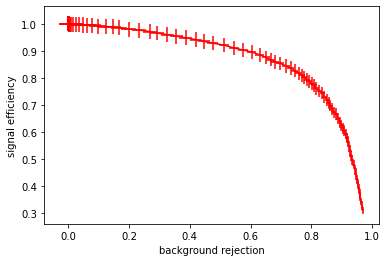

In [65]:
fig, ax = plt.subplots()
ax.errorbar(1-b,e, xerr=b_error, yerr=e_error, fmt = '-r')
plt.ylabel('signal efficiency')
plt.xlabel('background rejection')
#plt.title('Cut efficiency')

Text(0, 0.5, 'f.o.m.=e/sqrt(b)')

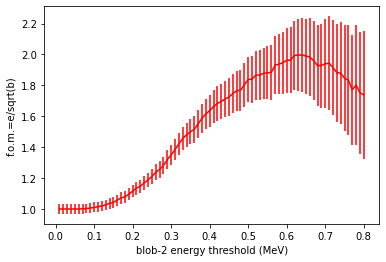

In [66]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,fom, yerr=fom_error,fmt = '-r')
plt.xlabel('blob-2 energy threshold (MeV)')
plt.ylabel('f.o.m.=e/sqrt(b)')
#plt.title('Cut efficiency')

In [67]:
myef.best_fom(e,b,fom,blobcut_energy)

Best fom is {1.9971306059114773}, that corresponds to:
- signal efficiency of 57.82%
- background acceptance of 8.38%
- energy threshold of 0.64 MeV


In [68]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/ntracks_DETSIM{testID}'
np.savez(npz_file, ntracks_0nubb=ntracks_0nubb, ntracks_eroi=ntracks_eroi)

In [75]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/ereco_DETSIM_R{blobR}mm{testID}'
np.savez(npz_file, reco_0nubb_e=reco_0nubb_e, reco_selectron_e=reco_selectron_e)

In [69]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/fom_DETSIM_R{blobR}mm{testID}'
np.savez(npz_file, e=e, b=b, fom=fom, e_error=e_error, b_error=b_error, fom_error=fom_error, blobcut_energy = blobcut_energy)

In [87]:
len(ntracks_0nubb_after)

2566

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

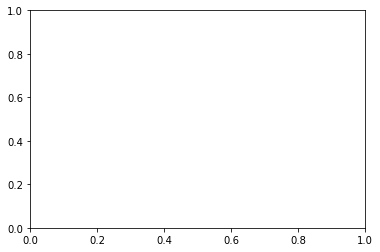

In [84]:
weights = myhf.get_weights(reco_selectron_e[1], True)
plt.hist2d(reco_0nubb_e[1], ntracks_0nubb_after, weights=weights, bins=(30, 10), range=((0, 1.5), (0, 10)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

### Testing selected events

In [70]:
len(reco_0nubb_e[2])

2518

In [71]:
events_noaccept = []
for i in range(len(reco_0nubb_e[2])):
    if reco_0nubb_e[2][i] < 0.46:
        events_noaccept.append(reco_0nubb_e[3][i])
events_noaccept

[7.0,
 8.0,
 21.0,
 56.0,
 72.0,
 88.0,
 135.0,
 136.0,
 139.0,
 148.0,
 167.0,
 175.0,
 184.0,
 196.0,
 197.0,
 212.0,
 216.0,
 220.0,
 235.0,
 236.0,
 245.0,
 259.0,
 292.0,
 320.0,
 333.0,
 344.0,
 366.0,
 367.0,
 379.0,
 395.0,
 411.0,
 415.0,
 441.0,
 442.0,
 444.0,
 446.0,
 448.0,
 453.0,
 517.0,
 545.0,
 591.0,
 616.0,
 625.0,
 631.0,
 644.0,
 680.0,
 700.0,
 722.0,
 729.0,
 794.0,
 825.0,
 831.0,
 847.0,
 866.0,
 871.0,
 874.0,
 875.0,
 894.0,
 926.0,
 961.0,
 968.0,
 985.0,
 990.0,
 1005.0,
 1028.0,
 1084.0,
 1104.0,
 1120.0,
 1163.0,
 1180.0,
 1187.0,
 1221.0,
 1225.0,
 1287.0,
 1335.0,
 1337.0,
 1342.0,
 1349.0,
 1356.0,
 1386.0,
 1391.0,
 1406.0,
 1424.0,
 1447.0,
 1535.0,
 1552.0,
 1556.0,
 1566.0,
 1568.0,
 1580.0,
 1597.0,
 1608.0,
 1616.0,
 1623.0,
 1624.0,
 1628.0,
 1635.0,
 1657.0,
 1681.0,
 1693.0,
 1697.0,
 1738.0,
 1739.0,
 1742.0,
 1755.0,
 1773.0,
 1787.0,
 1793.0,
 1811.0,
 1877.0,
 1886.0,
 1902.0,
 1911.0,
 1941.0,
 1945.0,
 1967.0,
 1970.0,
 1983.0,
 1998.0,
